### pre-process the JMA hindcasts, step 2, adopt the same file structure and convention as the CDS

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from datetime import datetime, timedelta

In [3]:
import pygrib
import numpy as np
import pandas as pd

In [4]:
import xarray as xr; print(xr.__version__)

0.14.0


In [5]:
import dask

In [6]:
import os

In [7]:
import pathlib

In [8]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [9]:
var = 'PRECIP'

In [10]:
model = 'JMA'

In [11]:
dpath = pathlib.Path(f'/home/nicolasf/drives/auck_projects/END19101/Working/data/hindcasts/{model}/{var}/')

In [12]:
lfiles = list(dpath.glob("*.nc"))

In [13]:
len(lfiles)

864

In [14]:
lfiles.sort()

In [15]:
print(lfiles[0])

/home/nicolasf/drives/auck_projects/END19101/Working/data/hindcasts/JMA/PRECIP/surf_Prr_mon.19790116.nc


In [16]:
print(lfiles[-1])

/home/nicolasf/drives/auck_projects/END19101/Working/data/hindcasts/JMA/PRECIP/surf_Prr_mon.20141227.nc


### read with mfdataset (needs dask installed )

In [17]:
dset = xr.open_mfdataset(lfiles, combine='by_coords')

In [18]:
dset

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 144, number: 5, step: 7, time: 864)
Coordinates:
  * number     (number) int64 0 1 2 3 4
  * latitude   (latitude) float64 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * step       (step) int64 1 2 3 4 5 6 7
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1979-01-16 1979-01-31 ... 2014-12-27
Data variables:
    precip     (time, step, number, latitude, longitude) float64 dask.array<chunksize=(1, 7, 5, 73, 144), meta=np.ndarray>

In [19]:
dset = dset.rename({'number':'member'})

In [20]:
dset

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 144, member: 5, step: 7, time: 864)
Coordinates:
  * member     (member) int64 0 1 2 3 4
  * latitude   (latitude) float64 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * step       (step) int64 1 2 3 4 5 6 7
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1979-01-16 1979-01-31 ... 2014-12-27
Data variables:
    precip     (time, step, member, latitude, longitude) float64 dask.array<chunksize=(1, 7, 5, 73, 144), meta=np.ndarray>

In [21]:
index = dset.time.to_series()

In [22]:
index = index[(index.index.day >= 10) & (index.index.day <= 16)]

In [23]:
dset = dset.sel(time=index.index)

In [24]:
dset.nbytes / 1e9

1.271536808

### normalise so that the initialisation date is the first of each month, we will keep the original 'real' initialisation dates in a separate variable 

In [25]:
init_dates = dset.time

In [26]:
init_dates = init_dates.to_index()

In [27]:
init_dates_fl = [datetime(x.year, x.month, 1) for x in init_dates]

In [28]:
dset['time'] = (('time'), init_dates_fl)

In [29]:
dset['init_dates_JMA'] = (('time'), init_dates)

### calculates the rolling averages over the `step` dimension 

In [30]:
dset

<xarray.Dataset>
Dimensions:         (latitude: 73, longitude: 144, member: 5, step: 7, time: 432)
Coordinates:
  * member          (member) int64 0 1 2 3 4
  * latitude        (latitude) float64 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * step            (step) int64 1 2 3 4 5 6 7
  * longitude       (longitude) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time            (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2014-12-01
Data variables:
    precip          (time, step, member, latitude, longitude) float64 dask.array<chunksize=(1, 7, 5, 73, 144), meta=np.ndarray>
    init_dates_JMA  (time) datetime64[ns] 1979-01-16 1979-02-10 ... 2014-12-12

In [31]:
dset_rm = dset.rolling({'step':3}, min_periods=3).mean()

In [32]:
dset_rm

<xarray.Dataset>
Dimensions:         (latitude: 73, longitude: 144, member: 5, step: 7, time: 432)
Coordinates:
  * member          (member) int64 0 1 2 3 4
  * latitude        (latitude) float64 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * step            (step) int64 1 2 3 4 5 6 7
  * longitude       (longitude) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time            (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2014-12-01
Data variables:
    precip          (time, step, member, latitude, longitude) float64 dask.array<chunksize=(1, 1, 5, 73, 144), meta=np.ndarray>
    init_dates_JMA  (time) datetime64[ns] 1979-01-16 1979-02-10 ... 2014-12-12

### selects from step (leadtime) 3 onwards 

In [33]:
dset_rm = dset_rm.sel(step=slice(3,None))

In [34]:
dset_rm

<xarray.Dataset>
Dimensions:         (latitude: 73, longitude: 144, member: 5, step: 5, time: 432)
Coordinates:
  * member          (member) int64 0 1 2 3 4
  * latitude        (latitude) float64 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * step            (step) int64 3 4 5 6 7
  * longitude       (longitude) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time            (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2014-12-01
Data variables:
    precip          (time, step, member, latitude, longitude) float64 dask.array<chunksize=(1, 5, 5, 73, 144), meta=np.ndarray>
    init_dates_JMA  (time) datetime64[ns] 1979-01-16 1979-02-10 ... 2014-12-12

### creates a variable `forecast_valid_time` which varies along the dimension time and step and contains the forecast validity dates 

In [35]:
lt_arr = []
for t in dset_rm.time.data: 
    lt = np.array([pd.to_datetime(t) + relativedelta(months=3), \
                   pd.to_datetime(t) + relativedelta(months=4), \
                   pd.to_datetime(t) + relativedelta(months=5), 
                  pd.to_datetime(t) + relativedelta(months=6), 
                  pd.to_datetime(t) + relativedelta(months=7)])
    lt_arr.append(lt)
lt_arr = np.array(lt_arr)
dset_rm['forecast_valid_time'] = (('time','step'), lt_arr)

In [36]:
dset_rm

<xarray.Dataset>
Dimensions:              (latitude: 73, longitude: 144, member: 5, step: 5, time: 432)
Coordinates:
  * member               (member) int64 0 1 2 3 4
  * latitude             (latitude) float64 90.0 87.5 85.0 ... -85.0 -87.5 -90.0
  * step                 (step) int64 3 4 5 6 7
  * longitude            (longitude) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * time                 (time) datetime64[ns] 1979-01-01 ... 2014-12-01
Data variables:
    precip               (time, step, member, latitude, longitude) float64 dask.array<chunksize=(1, 5, 5, 73, 144), meta=np.ndarray>
    init_dates_JMA       (time) datetime64[ns] 1979-01-16 ... 2014-12-12
    forecast_valid_time  (time, step) datetime64[ns] 1979-04-01 ... 2015-07-01

### rename GH to Z for compat 

In [37]:
if var == 'gh': 
    dset_rm = dset_rm.rename_vars({'gh':'z'})
    
if var == 'T2M': 
    dset_rm = dset_rm.rename_vars({'2t':'t2m'})

In [38]:
dset_rm

<xarray.Dataset>
Dimensions:              (latitude: 73, longitude: 144, member: 5, step: 5, time: 432)
Coordinates:
  * member               (member) int64 0 1 2 3 4
  * latitude             (latitude) float64 90.0 87.5 85.0 ... -85.0 -87.5 -90.0
  * step                 (step) int64 3 4 5 6 7
  * longitude            (longitude) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * time                 (time) datetime64[ns] 1979-01-01 ... 2014-12-01
Data variables:
    precip               (time, step, member, latitude, longitude) float64 dask.array<chunksize=(1, 5, 5, 73, 144), meta=np.ndarray>
    init_dates_JMA       (time) datetime64[ns] 1979-01-16 ... 2014-12-12
    forecast_valid_time  (time, step) datetime64[ns] 1979-04-01 ... 2015-07-01

### longitude goes from 0 to 360 already, so no need to change 

In [39]:
dset_rm.longitude

<xarray.DataArray 'longitude' (longitude: 144)>
array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,
        25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,  47.5,
        50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,  67.5,  70. ,  72.5,
        75. ,  77.5,  80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5,
       100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5, 120. , 122.5,
       125. , 127.5, 130. , 132.5, 135. , 137.5, 140. , 142.5, 145. , 147.5,
       150. , 152.5, 155. , 157.5, 160. , 162.5, 165. , 167.5, 170. , 172.5,
       175. , 177.5, 180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5,
       200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
       225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. , 247.5,
       250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5, 270. , 272.5,
       275. , 277.5, 280. , 282.5, 285. , 287.5, 290. , 292.5, 295. , 297.5,
       300. , 302.5, 305. , 

### pattern of filenames taken from the ECMWF hindcasts 

filename is VAR_hindcasts_{yearstart}_{yearend}_{model}_seasonal.nc

In [40]:
var.upper()

'PRECIP'

In [41]:
yearstart = pd.to_datetime(dset_rm.time[0].data).year 

In [42]:
yearend = pd.to_datetime(dset_rm.time[-1].data).year 

In [43]:
yearstart

1979

In [44]:
yearend

2014

In [45]:
filename_out = f"{var.upper()}_hindcasts_{yearstart}_{yearend}_{model}_seasonal.nc"

In [46]:
filename_out

'PRECIP_hindcasts_1979_2014_JMA_seasonal.nc'

### saves to disk 

In [47]:
dset_rm.to_netcdf(dpath / filename_out)

### now calculates the anomalies with respect to the 1981 - 2010 period 

In [48]:
def demean(x): 
    return x - x.sel(time=slice('1993','2016')).mean('time')

In [49]:
anoms_rm = dset_rm.groupby('time.month').apply(demean)

In [50]:
anoms_rm['forecast_valid_time'] = (('time','step'), dset_rm.forecast_valid_time)

In [51]:
anoms_rm

<xarray.Dataset>
Dimensions:              (latitude: 73, longitude: 144, member: 5, step: 5, time: 432)
Coordinates:
  * member               (member) int64 0 1 2 3 4
  * latitude             (latitude) float64 90.0 87.5 85.0 ... -85.0 -87.5 -90.0
  * step                 (step) int64 3 4 5 6 7
  * longitude            (longitude) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * time                 (time) datetime64[ns] 1979-01-01 ... 2014-12-01
Data variables:
    precip               (time, step, member, latitude, longitude) float64 dask.array<chunksize=(1, 5, 5, 73, 144), meta=np.ndarray>
    month                (time) int64 1 2 3 4 5 6 7 8 9 ... 4 5 6 7 8 9 10 11 12
    forecast_valid_time  (time, step) datetime64[ns] 1979-04-01 ... 2015-07-01

In [52]:
filename_out = f"{var.upper()}_hindcasts_{yearstart}_{yearend}_{model}_seasonal_anomalies.nc"

In [53]:
filename_out

'PRECIP_hindcasts_1979_2014_JMA_seasonal_anomalies.nc'

In [54]:
anoms_rm.to_netcdf(dpath / filename_out)

In [57]:
anoms_rm

<xarray.Dataset>
Dimensions:              (latitude: 73, longitude: 144, member: 5, step: 5, time: 432)
Coordinates:
  * member               (member) int64 0 1 2 3 4
  * latitude             (latitude) float64 90.0 87.5 85.0 ... -85.0 -87.5 -90.0
  * step                 (step) int64 3 4 5 6 7
  * longitude            (longitude) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * time                 (time) datetime64[ns] 1979-01-01 ... 2014-12-01
Data variables:
    precip               (time, step, member, latitude, longitude) float64 dask.array<chunksize=(1, 5, 5, 73, 144), meta=np.ndarray>
    month                (time) int64 1 2 3 4 5 6 7 8 9 ... 4 5 6 7 8 9 10 11 12
    forecast_valid_time  (time, step) datetime64[ns] 1979-04-01 ... 2015-07-01

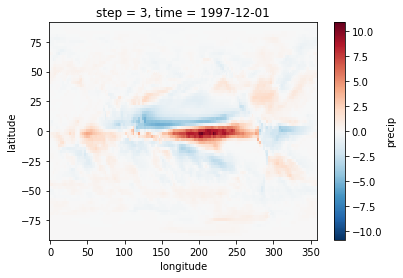

In [59]:
anoms_rm.sel(time='1997-12-01').sel(step=3).mean('member')['precip'].plot()